# Product Analytics with SQL and Python

This is an analytics report which analyzes consumer behavior, trends and significant findings for relationships between Thumbtack service professionals

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import sys
!{sys.executable} -m pip install pandasql
from pandasql import sqldf
from pandasql import *
import calendar

In [7]:
visitors=pd.read_csv("visitors.csv")


In [36]:
quotes=pd.read_csv("quotes.csv")
quotes.head(20)


,request_id,quote_id,quote_price,hired,pro_id
0,1,38912310,NaN,0,851539
1,1,38912311,210.0,0,10113954
2,1,38913628,NaN,0,13498826
3,1,38914071,NaN,0,15921289
4,1,38912344,NaN,0,14506387
5,2,39189751,175.0,0,76329
6,2,39189531,100.0,1,10995392
7,3,38146708,NaN,0,5836949
8,3,38178389,NaN,0,5918823
9,4,38192457,100.0,0,15728846


# (1) Visitors and Conversion Rate

##  How does the number of visitors change over time?

-  We are only looking at the essential "traffic" for Thumbtack (in other words, we are interested in visitors regardless of whether they submitted a request or not).

-  In order to work with our dates in an easier manner, it is useful to take the session date variable we have to extract different variables of year, month, and day. This will allow us to select certain parts of a datetime to exhibit visitor change over time.

In [9]:
visitors['session_date'] = pd.to_datetime(visitors['session_date']) 
visitors['year'] = visitors['session_date'].dt.year
visitors['month'] = visitors['session_date'].dt.month
visitors['day'] = visitors['session_date'].dt.day
visitors['month'] = visitors['month'].apply(lambda x: calendar.month_abbr[x])

- We noticed that our data of visitors actually comes from the same year and same month being August 2016, by looking at our created year and month columns. To show a change over time, we essentially need to see how the number of visitors changes throughout different days in the month of August in 2016. 

In [10]:
pysqldf = lambda q: sqldf(q, globals())
q="""SELECT day AS DAY, COUNT(*) AS COUNT FROM visitors GROUP BY day;"""
data=pd.DataFrame(pysqldf(q))


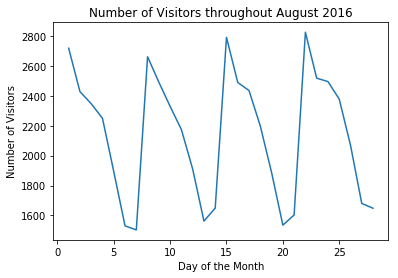

In [14]:
import matplotlib.pyplot as plt
plt.subplot(1,1,1)
plt.plot(data.DAY, data.COUNT)
plt.title('Number of Visitors throughout August 2016')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Visitors')
plt.show()


-  From the line graph above, it is evident that the number of visitors over this 28 day span does vary a lot. There are large increases between differences of 1 or 2 days, and there are decreases throughout the month too. Decreases in number of visitors usually occur for about 6 days until they reach an abrupt increasing point. 

- Looking back at the calendar for August 2016, we discover that days of the week in which the number of visitors are low correspond to weekends or Fridays. In addition, all the high peeks occured on Mondays. Clearly users seem to be flocking into Thumbtack more heavily on certain days!

## What percent of visitors submit a project request?

In [15]:
visitors.sent_request.value_counts()


1    34146
0    25850
Name: sent_request, dtype: int64

In [16]:
df=pd.DataFrame({'Users': [ 'Requested','No Request'],
                 'Percentage': [((34146/(34146+25850))*100),
                                (25850/(34146+25850))*100],})

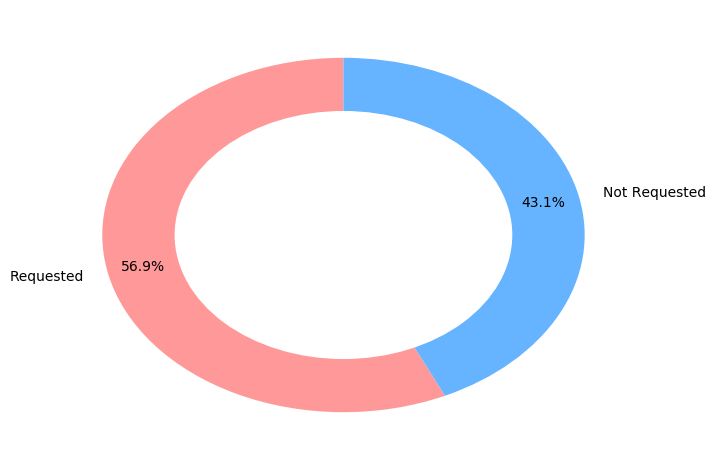

In [17]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
labels = 'Requested','Not Requested'
sizes = [34146,25850]
explode = (0,0)
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%'
        , startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()
plt.show()

-  The above pie chart indicates once more that there is a greater percentage of visitors that did submit a request!

## How do category and device influence these metrics?

### Device

In [18]:
q="""SELECT *, ROUND(Requested_Counts/Total_COUNTS,2) AS Proportion_Requested FROM
(SELECT device,COUNT(*) AS Total_COUNTS,CAST(SUM(sent_request=1) AS FLOAT) AS Requested_Counts
FROM visitors GROUP BY device);"""
data=pd.DataFrame(pysqldf(q))
data



,device,Total_COUNTS,Requested_Counts,Proportion_Requested
0,desktop,32295,18708.0,0.58
1,mobile,27701,15438.0,0.56


-  From the above table, it is evident that individuals that started request forms using a desktop actually ended up submitting a request more often than those we engaged with a mobile (58% vs 56% respectively).

### Two sample proportion z-test for difference in proportions

Null Hypothesis : Proportions are the same

Alternative Hypothesis : Proportions are not the same

In [19]:
import statsmodels.api as sm
z1, p_value1 = sm.stats.proportions_ztest([18708.0, 15438.0], [32295, 27701])

print(['{:.12f}'.format(b) for b in (z1, p_value1)])

['5.419151179011', '0.000000059883']


-  Our p value (the second number in the result) is lower than alpha = 0.05 (our tolerance). Since our probability is <1%, this basically means given that there is no difference in proportions, we would obtain our observed difference in proportions or more in less than 1% of studies, due to random sampling error. Because our p-value is below our tolerance, we have evidence to **reject** the null hypothesis of no difference in proportions at the alpha=0.05 level. Our sample was so inconsistent with the null hypothesis that we may reject it for the population. Now we have a baseline of how the request measure differs with respect to device type.

### Hypotheses for desktop vs mobile users ~ differences in percentage that requested

-  Research has shown us that during recent years, the number of **visits** from a mobile device to a business has surpassed desktop users from 57% to 63% (Source: stonetemple.com) However, **it is a different case when actual purchasing from the business is considered.** For example, Demetrius Williams of translatemedia noted the success that desktop purchasing has in ecommerce when he claimed, "Customers are more comfortable making final purchase decisions on expensive items on desktop screens as site navigation is less cumbersome" (Source: translatemedia). Though submitting a request for quotes on Thumbtack is not the final step of purchase, the reasoning may be powerful enough that Thumbtack analysts can regard this popular trend as to explain some of the reason why decisions of submitting requests occur more frequently on the desktop.

-  The first indicator mobile experience may need to be improved is that though mobile device visits are now more common than desktops, this is the opposite as seen for Thumbtack in our above data of counts! Secondly, the difference in proportions of request submissions could be explained by a lack of quality with interaction and visual design in apps or mobile sites. This user experience is important for product designers and the data above could be of meaningful insight that product designers at Thumbtack need to improve the functionality of apps. For example, people may be spending too much time using the app and don't end up submitting a request, or there could be a lack of understanding of using the app.

### Category

In [20]:
q="""SELECT *, ROUND(Requested_Counts/Total_COUNTS,2) AS Proportion_Requested FROM 
(SELECT category_name,COUNT(*) AS Total_COUNTS,CAST(SUM(sent_request=1) AS FLOAT)
AS Requested_Counts FROM
visitors GROUP BY category_name);"""
data1=pd.DataFrame(pysqldf(q))
data1


,category_name,Total_COUNTS,Requested_Counts,Proportion_Requested
0,House Cleaning (One Time),17347,10966.0,0.63
1,Local Moving (under 50 miles),42649,23180.0,0.54


-  We see from this table that though local moving was the more popular category, submission requests were more common for house cleaning than local moving (63% vs 54% requested, respectively).

### Two sample proportion z-test for difference in proportions

In [21]:
z1, p_value1 = sm.stats.proportions_ztest([10966.0, 23180.0], [17347, 42649])

print(['{:.12f}'.format(b) for b in (z1, p_value1)])

['19.879341876320', '0.000000000000']


-  Similarly as before, we **reject** the null hypothesis that the two population proportions of requests for each category are not different.

### Hypotheses for House Cleaning / Local Moving ~ differences in percentage that requested

- As a visitor was filling out the detailed specifications of the local moving project, they may have gained more information about how the moving process will be done. They, for example, could have realized the process was easier than they initially thought and the moving truck rental alone is sufficient. They may have turned to established companies like U-HAUL to do so. There are reasons that visitors looking for home cleaning will more likely submit a quote request. If they had engaged in starting a request, there would be less of a chance that they would turn to other methods. For example, they likely would not rent cleaning supplies for the house and then perform the service themselves as those items are inexpensive and not suitable for renting. 

- This data may be exlusive to a particular region in which there is a growing movement away from the region to nearby cities within 50 miles. If this is the case, there will be more demand and therefore prices of the pros would increase. Thumbtack users may have searched their service in their region for general prices and decided to go after cheaper alternatives such as U-HAUL.

# (2) Quotes Per Request

## What is the distribution of the number of quotes per request?

-  Because we are investgating requests and their respective quotes, we need to perform a join on the two tables. We consider an inner join on the request id that will return the intersection of two tables.

In [22]:
Full = pd.merge(visitors,
                 quotes,
                 on='request_id')

In [23]:
q="""SELECT * FROM Full ORDER BY request_id;"""
data1=pd.DataFrame(pysqldf(q))

In [24]:
q="""SELECT request_id, COUNT(*) AS Number_Quotes FROM data1 GROUP BY request_id;"""
Dist=pd.DataFrame(pysqldf(q))




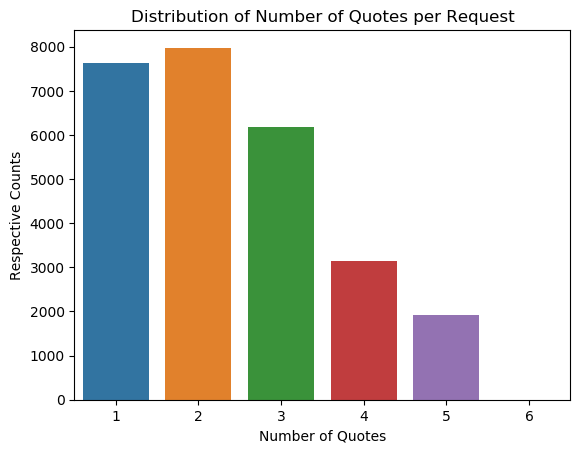

In [25]:
import seaborn as sns
ax = sns.countplot(x="Number_Quotes", data=Dist)
ax.set_title("Distribution of Number of Quotes per Request")
ax.set(xlabel='Number of Quotes',ylabel='Respective Counts')
plt.show()

-  We see from above that the distribution of number of quotes per request is skewed to the right because it has a long tail from values of 2 to 5. There is a long tail is the positive direction of the number line, and the mean is located to the right of the peak, at 2.395. The most commonly occuring number of quotes was 2, and the least was 5.

## What factors contribute to some requests getting more quotes than others?

### For local moving, it would be interesting to see how the distance in miles can affect # quotes given

In [26]:
q="""SELECT how_far, ROUND(AVG(COUNT),3) AS Average_Number_Quotes 
FROM(SELECT request_id, how_far,
COUNT(*) AS COUNT FROM Full WHERE category_name LIKE 'Local%'
AND how_far IS NOT NULL GROUP BY
request_id,how_far) GROUP BY how_far;"""
Tab=pd.DataFrame(pysqldf(q))
Tab1=Tab.reindex([5,4,3,0,1,2])



In [27]:
q="""SELECT Distance, Average_Number_Quotes FROM(SELECT *, CASE WHEN 
how_far='Within the same building' then 'Same Area'
                    WHEN how_far='Less than 5 miles' then '<5'
                    WHEN how_far='5 - 10 miles' then '5-10'
                    WHEN how_far='11 - 20 miles' then '11-20'
                    WHEN how_far='21 - 30 miles' then '21-30'
                    WHEN how_far='31 - 50 miles' then '31-50' 
                    END AS Distance FROM Tab1);"""
Tab2=pd.DataFrame(pysqldf(q))


[Text(0,0.5,'Average Number of Quotes'), Text(0.5,0,'Distance (miles)')]

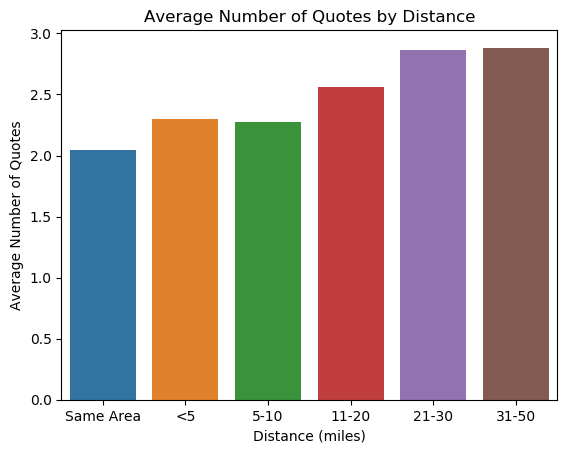

In [28]:
ax = sns.barplot(x="Distance", y="Average_Number_Quotes", data=Tab2)
ax.set_title("Average Number of Quotes by Distance")
ax.set(xlabel='Distance (miles)',ylabel='Average Number of Quotes')


-  From the bar chart above we see that as the distance in miles increases for the location of move, the requester tends to get more quotes for a moving service.

### The effect of the number of Bedrooms on number of quotes

In [29]:
q="""SELECT Bedrooms, AVG(Quotes) AS Average_Quotes
FROM(SELECT Bedrooms, request_id, COUNT(*) AS Quotes
FROM(SELECT *, SUBSTR(num_bedrooms,1,1) AS Bedrooms FROM Full
WHERE category_name LIKE 'House%' AND num_bedrooms IS NOT NULL)
GROUP BY Bedrooms,request_id) GROUP BY Bedrooms;"""
Tab2=pd.DataFrame(pysqldf(q))
Tab3=Tab2.reindex([5,0,1,2,3,4])
Tab3=Tab3.replace({'S': 'Studio', '5':'5+'}, regex=True)

[Text(0,0.5,'Average Number of Quotes'), Text(0.5,0,'Bedroom Count or Studio')]

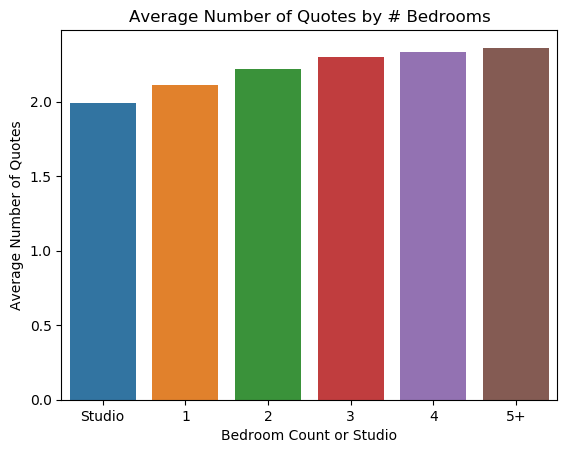

In [30]:
ax = sns.barplot(x="Bedrooms", y="Average_Quotes", data=Tab3)
ax.set_title("Average Number of Quotes by # Bedrooms")
ax.set(xlabel='Bedroom Count or Studio',ylabel='Average Number of Quotes')


-  Again,we see a similar trend from the above table and barplot being that as we increase the bedroom count of the home (and therefore generally the size of the home), there are more quotes given.

### Hypotheses & explanations for why some requests recieve more quotes

-  We saw similar results when we looked into distance for house moving and number of bedrooms for cleaning with respect to average number of quotes. Increasing the distance of moving homes and # of bedrooms both may correspond to longer time needed to complete the service. Therefore, we can conclude our findings by noting that the pros prefer customers that demand more, and thus more time needed to complete the project. This may be because they would rather stick to one customer for a long period of time than to go around the city and find 2 or 3 customers to work for during the same time frame. Communication with these customer and reading each of their requests and demands in the form is more time consuming, and time is money!

# (3) Job Value

### For each category, what is the distribution of quote prices for a project?

#### Data Preprocessing before distribution analysis

In [31]:
Full.quote_price.describe()

count    31554.000000
mean       242.516896
std        273.232394
min          0.000000
25%        120.000000
50%        195.000000
75%        350.000000
max      25504.000000
Name: quote_price, dtype: float64

In [32]:
print(sum(Full.quote_price.isna()))

32776


-  We first need to explain some of the summary statistics for quote prices. Firstly, it is hard to believe that the max cost of a quote would be 25,000 dollars for any service of moving under 50 miles, or cleaning one's home. This observation could be neglected in future analysis because it is an outlier, could be a mistake, or a different currency of which we do not know.



-  We can infer quote prices of 0 to mean pros that are offering their service free for first time customers or just a general special deal.



-  NAs in the quote prices may mean that the pro was unable to provide a quote based on the limited information a customer provided in their request form. Another possibility is they may represent a quote of a large range of money, but are included as NAs because it is not a single number. 



-  We will remove observations of quote prices that are beyond the 99.9th percentile for prices. We believe these to be very likely false and a mistake. In addition, we purge rows with NAs for observing price distributions.



In [33]:
q="""SELECT * FROM Full WHERE quote_price IS NOT NULL;"""
Prices=pd.DataFrame(pysqldf(q))
Prices=Prices[Prices.quote_price <= Prices.quote_price.quantile(.999)]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E79161E780>,
      dtype=object)

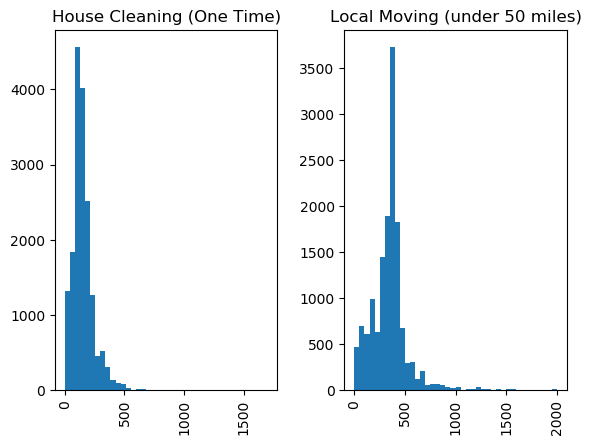

In [34]:
Prices['quote_price'].hist(by=Prices['category_name'],bins=40)

-  The tallest cluster of bars represent the most common values. For house cleaning, more commonly they were quoted figures of about 150. For local moving the numbers were slightly higher of about 350 dollars. The house cleaning histogram spread was from 0 to about 600, and 0 to 2000 for local moving. The house cleaning distribution is skewed to the right. This means most of the sampled values are gathered on the right side of the histogram. The local moving distribution is clearly unimodal because it is more bell shaped than house cleaning and has only one clear peak.



### For each category, what is an appropriate price for Thumbtack to charge pros to quote?

-  We have reason to believe that Thumbtack should charge local moving pros more for quotes than house cleaning. The reason there should be reasonable difference between the price of quotes is due to the cost of the service that the customer will be paying for. We got a sense of this when distribution analysis indicated local moving quotes are on average more than twice as costly as home cleaning. To clarify further, one can imagine pros that provide services having large returns of 1000+ dollars will be willing to spend more on quotes to introduce themselves than if the service costed 80 dollars.

In [35]:
q="""SELECT category_name, hired, ROUND(AVG(quote_price),2)
AS Mean_Quote_Price FROM Full GROUP BY category_name,hired;"""
group=pd.DataFrame(pysqldf(q))
group.head()

,category_name,hired,Mean_Quote_Price
0,House Cleaning (One Time),0,153.99
1,House Cleaning (One Time),1,143.23
2,Local Moving (under 50 miles),0,355.14
3,Local Moving (under 50 miles),1,326.88


-  We should first remind ourselves that charging for quotes  could lead to pros raising their quotes to make up for the cost. And with this action, prices would rise and less pros may be hired. Looking at the table above the mean hired quote price for house cleaning pros was at 143.23. If Thumbtack were to charge 10 dollars for each of the pros to put up a quote, the pros might make up for it and instead charge about 154 and that is the mean quote price for the pros that were not hired! Even though Thumbtack earns 10% of the revenue after bookings, if bookings are not made then that is a serious issue. Similarly, charging 28 dollars for quotes for local moving pros would bring the mean quote price for the hired to about 355, the typical price where the pros do not get hired!

-  Reccomendation : Charge half the amount of dollars it takes to reach the mean quote prices for those non-hired pros.  5 dollars for house cleaners pros to quote, and 14 dollars for local moving pros to quote.

# (4) Further Exploration

- It will be useful to develop machine learning methods for predicting the binary response variable "hired". Explatory analysis should be conducted first to decide which variables should be included in the model for predictive purposes. In addition, other variables such as the rating of the pro on Thumbtack or the number of reviews if they are in other data sets would provide more value into this analysis. We can consider methods of logistic regression, random forest, support vector machines and compare their accuracies on testing data (future data) when used on training data.

- If we had text/review data for visitors that did not write a request and explained why they did so, we can construct word clouds which would give us a general sense of what those visitors are saying and popular words they use to explain why they abandoned their request form. 

# (5) References for Supporting Hypotheses

Enge, E. (2018, April 27). Mobile vs Desktop Usage in 2018: Mobile widens the gap. Retrieved from https://www.stonetemple.com/mobile-vs-desktop-usage-study/

Williams, D. (2018, September 20). Bridging the Gap Between Mobile and Desktop eCommerce Customers. Retrieved from https://www.translatemedia.com/us/blog-usa/bridging-gap-mobile-desktop-ecommerce-customers/